By Thomas Vugia and Bryan Linares for CSULB class CECS 571 Summer 2024

In [ ]:
!pip install mkwikidata

In [ ]:
# 1 - Install, import mkwikidata
import mkwikidata
import pandas as pd
from pandas import json_normalize

In [ ]:
#2 Query 1: Show all narrative cities of books and literary works and their geo coords
#wd:Q571, wd:Q7725634,   wd:Q515, wdt:P31,     wdt:P840,           wdt:P625 ,           wdt:P279
#book,    literary work, city,    instance of, narrative location, coordinate location, subclass of

#select the cities and their geo coords
query = """
SELECT ?book ?bookLabel ?narrative_location ?narrative_locationLabel ?coord
WHERE
{
  VALUES ?type {wd:Q571 wd:Q7725634} # get book or literary work
  ?book wdt:P840 ?narrative_location; # get narrative locations
        wdt:P31 ?type . #instance of those types

  VALUES ?city {wd:Q515} # get only cities
  ?narrative_location wdt:P625 ?coord ;
                      wdt:P31 ?city.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
LIMIT 100
"""

# Execute the query
results = mkwikidata.run_query(query, params={})

# Normalize the JSON result into a DataFrame
df = json_normalize(results['results']['bindings'])

# Display the relevant columns for readability
df = df.rename(columns={"book.value": "Book ID", "bookLabel.value": "Book Name",
                        "narrative_location.value": "City ID", "narrative_locationLabel.value": "City Name",
                        "coord.value": "Coordinates"}
)

#print(results)
df[['Book ID', 'Book Name', 'City ID', 'City Name', 'Coordinates']].head(100)

,Book ID,Book Name,City ID,City Name,Coordinates
0,http://www.wikidata.org/entity/Q605249,Do Androids Dream of Electric Sheep?,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
1,http://www.wikidata.org/entity/Q615651,Now and Forever,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
2,http://www.wikidata.org/entity/Q738937,Our Lady of Darkness,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
3,http://www.wikidata.org/entity/Q743180,On the Road,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
4,http://www.wikidata.org/entity/Q749783,The Man in the High Castle,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
...,...,...,...,...,...
95,http://www.wikidata.org/entity/Q7735776,The Gangster of Love,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
96,http://www.wikidata.org/entity/Q7737041,The Golden Gate,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
97,http://www.wikidata.org/entity/Q7737043,The Golden Gate,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)
98,http://www.wikidata.org/entity/Q7737864,The Great Night,http://www.wikidata.org/entity/Q62,San Francisco,Point(-122.416388888 37.7775)


In [ ]:
# 3 What is the most common narration country in Wikidata books and literature works?

query = """
SELECT ?countryLabel (COUNT(?book) as ?bookcount)
WHERE
{
  VALUES ?type {wd:Q571 wd:Q7725634}
  ?book wdt:P840 ?narrative_location;
        wdt:P31 ?type .
  VALUES ?city {wd:Q515}
  ?narrative_location wdt:P31 ?city;
                      wdt:P17 ?country.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
GROUP BY ?countryLabel
ORDER BY DESC(?bookcount)
LIMIT 5000
"""

# Execute the query
results = mkwikidata.run_query(query, params={})

# Normalize the JSON result into a DataFrame
df = json_normalize(results['results']['bindings'])

# Display the relevant columns for readability
df = df.rename(columns={"countryLabel.value": "Country", "bookcount.value": "Count"}
)

#print(results)
df[['Country', 'Count']].head(100)

,Country,Count
0,United Kingdom,723
1,Spain,250
2,United States of America,237
3,Italy,218
4,Serbia,58
...,...,...
88,Trinidad and Tobago,1
89,Colombia,1
90,Guatemala,1
91,Kingdom of León,1


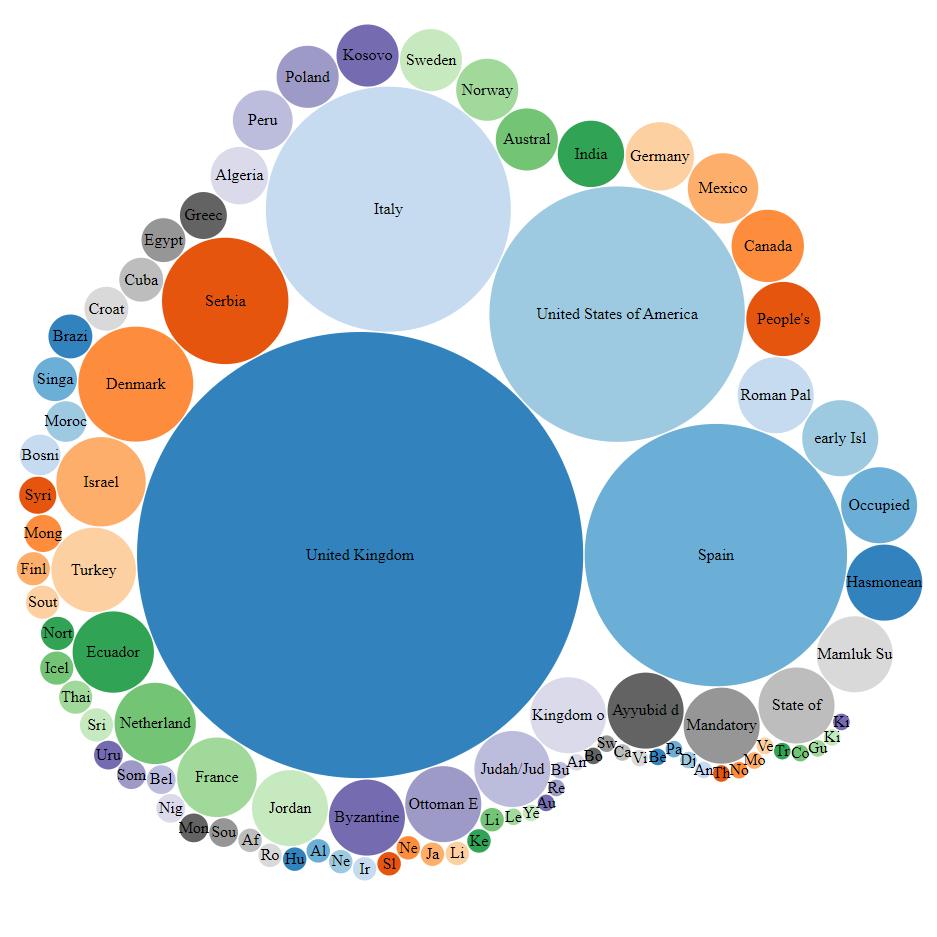

In [ ]:
# 4 Bubble Chart visualization using matplotlib?
# defaultView:BubbleChart
#Defaultview assumes using a wikidata renderer, here just upload our screenshot.

#show uploaded image
from IPython.display import Image
Image(filename='bubblechart.png')

In [ ]:
#SPARQL Wrapper
!pip install sparqlwrapper

In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
from pandas import json_normalize

In [ ]:
# 1- Most common cause of death among writers?
# wdt:P106, wdt:P509, wd:Q36180
# occupation, cause of death, writer

sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# From https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries/examples#Cats
sparql.setQuery("""
SELECT ?causeLabel (COUNT(?writer) as ?count)
WHERE {
  ?writer wdt:P106 wd:Q36180 .    #  writer (P106 = occupation, Q36180 = writer)
  ?writer wdt:P509 ?cause .        # cause of death (P509)

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
    ?cause rdfs:label ?causeLabel.
  }
}
GROUP BY ?causeLabel
ORDER BY DESC(?count)
LIMIT 20
""")

sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#print(results)
results_df = json_normalize(results['results']['bindings'])
results_df = results_df.rename(columns={"causeLabel.value": "Cause", "count.value": "Count"})
results_df[['Cause', "Count"]].head()
#results_df[['item.value', 'itemLabel.value']].head()


,Cause,Count
0,cancer,1146
1,myocardial infarction,1117
2,tuberculosis,575
3,pneumonia,554
4,stroke,451


In [ ]:
# 2 - Only writers that died before 1800?
# Use Filter on previous to limit the results of the year of death property
sparql.setQuery("""
SELECT ?causeLabel (COUNT(?writer) as ?count)
WHERE {
      ?writer wdt:P106 wd:Q36180 .
      ?writer wdt:P509 ?cause .

      ?writer wdt:P570 ?death .        #death date
      # Filter for deaths before 1800
      FILTER(YEAR(?death) < 1800)

      SERVICE wikibase:label {
        bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
        # ?cause rdfs:label ?causeLabel.
        # ?writer rdfs:label ?writerLabel.
      }
}
GROUP BY ?causeLabel
ORDER BY DESC(?count)
LIMIT 20
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
#print(results)
results_df = json_normalize(results['results']['bindings'])
results_df = results_df.rename(columns={"causeLabel.value": "Cause", "count.value": "Count"})
results_df[['Cause', "Count"]].head()

,Cause,Count
0,decapitation,89
1,plague,65
2,disease,55
3,tuberculosis,45
4,death by burning,35


In [ ]:
#Querying DBPedia
# 1 - Show all Nobel laureates in Literature over the years, if available print out their thumbnail
# and description
# Initialize SPARQLWrapper for DBpedia
sparql = SPARQLWrapper("http://dbpedia.org/sparql")

# SPARQL query for Nobel Literature laureates
query = """
PREFIX dct: <http://purl.org/dc/terms/>

SELECT DISTINCT ?authorLabel ?desc ?thumbnail
WHERE {
  ?author dct:subject dbc:Nobel_laureates_in_Literature .
  ?author dbo:abstract ?desc .
  FILTER langMatches(lang(?desc), 'en') .
  ?author dbo:thumbnail ?thumbnail .
  ?author rdfs:label ?authorLabel .
  FILTER langMatches(lang(?authorLabel), 'en') .
}
LIMIT 20
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df = df.rename(columns={'authorLabel.value': 'Author', 'desc.value': 'Description', 'thumbnail.value': 'Thumbnail'})
df[['Author', 'Description', 'Thumbnail']].head(5)

,Author,Description,Thumbnail
0,Camilo José Cela,"Camilo José Cela y Trulock, 1st Marquess of Ir...",http://commons.wikimedia.org/wiki/Special:File...
1,Carl Spitteler,Carl Friedrich Georg Spitteler (24 April 1845 ...,http://commons.wikimedia.org/wiki/Special:File...
2,Pär Lagerkvist,Pär Fabian Lagerkvist (23 May 1891 – 11 July 1...,http://commons.wikimedia.org/wiki/Special:File...
3,Roger Martin du Gard,Roger Martin du Gard (French: [dy gaʁ]; 23 Mar...,http://commons.wikimedia.org/wiki/Special:File...
4,Romain Rolland,Romain Rolland (French: [ʁɔlɑ̃]; 29 January 18...,http://commons.wikimedia.org/wiki/Special:File...


In [ ]:
# 2 - List all the poets in DBPedia

# SPARQL query for all poets
query = """
PREFIX dct: <http://purl.org/dc/terms/>

SELECT DISTINCT ?poetLabel ?desc ?thumbnail
WHERE {
  ?poet dbo:occupation dbr:Poet .
  ?poet dbo:abstract ?desc .
  FILTER langMatches(lang(?desc), 'en') .
  ?poet dbo:thumbnail ?thumbnail .
  ?poet rdfs:label ?poetLabel .
  FILTER langMatches(lang(?poetLabel), 'en') .
}
LIMIT 20
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df = df.rename(columns={'poetLabel.value': 'Poet', 'desc.value': 'Description', 'thumbnail.value': 'Thumbnail'})
df[['Poet', 'Description', 'Thumbnail']].head(5)

,Poet,Description,Thumbnail
0,Cale Young Rice,"Cale Young Rice (December 7, 1872 – January 24...",http://commons.wikimedia.org/wiki/Special:File...
1,Camil Petrescu,Camil Petrescu (Romanian pronunciation: [kaˈmi...,http://commons.wikimedia.org/wiki/Special:File...
2,Camille Dungy,Camille T. Dungy (born 1972) is an American po...,http://commons.wikimedia.org/wiki/Special:File...
3,Cao Shui,Cao Shui (simplified Chinese: 曹谁; traditional ...,http://commons.wikimedia.org/wiki/Special:File...
4,Carel Steven Adama van Scheltema,"Carel Steven Adama van Scheltema (Amsterdam, 2...",http://commons.wikimedia.org/wiki/Special:File...


In [ ]:
#Linked Stage Graph
# 1 - In LSG select all resources which list a contributor, for this contributor,
# retrieve their birth year and place from wikidata
# wdt:P19, wdt:P569
sparql = SPARQLWrapper("https://zbw.eu/beta/sparql/gnd/query")

query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

select ?resource ?contributor ?contributor_name ?wikidata_contributor ?wikidata_contributorLabel ?birthDate ?birthPlace ?birthPlaceLabel
where {
  ?resource gndo:creator ?contributor .
  ?contributor gndo:preferredNameForThePerson ?contributor_name ;
               owl:sameAs ?wikidata_contributor .
  SERVICE <https://query.wikidata.org/sparql> {
    ?wikidata_contributor wdt:P569 ?birthDate . # Birth date
    OPTIONAL { ?wikidata_contributor wdt:P19 ?birthPlace . }  # Birth place (if available)
    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
      ?wikidata_contributor rdfs:label ?wikidata_contributorLabel .
      ?birthPlace rdfs:label ?birthPlaceLabel .
    }
  }
}
limit 20
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df = df.rename(columns={'resource.value': 'Resource', 'contributor.value': 'Contributor ID', 'contributor_name.value': 'Contributor Name',
                        'wikidata_contributor.value': 'Wikidata Contrib. ID', 'wikidata_contributorLabel.value': 'WD Contrib Name',
                        'birthDate.value': 'Birthday', 'birthPlace.value': 'Birth place ID', 'birthPlaceLabel.value': 'Birth place'})
df[['Resource', 'Contributor ID', 'Contributor Name',
    'Wikidata Contrib. ID', 'WD Contrib Name',
    'Birthday', 'Birth place ID', 'Birth place'
    ]].head(10)

,Resource,Contributor ID,Contributor Name,Wikidata Contrib. ID,WD Contrib Name,Birthday,Birth place ID,Birth place
0,https://d-nb.info/gnd/117546788X,https://d-nb.info/gnd/117458201,"Wolbe, Eugen",http://www.wikidata.org/entity/Q1372969,Eugen Wolbe,1873-04-06T00:00:00Z,http://www.wikidata.org/entity/Q64,Berlin
1,https://d-nb.info/gnd/1054180407,https://d-nb.info/gnd/118634674,"Wolf, Friedrich",http://www.wikidata.org/entity/Q77447,Friedrich Wolf,1888-12-23T00:00:00Z,http://www.wikidata.org/entity/Q3967,Neuwied
2,https://d-nb.info/gnd/1155788958,https://d-nb.info/gnd/118634674,"Wolf, Friedrich",http://www.wikidata.org/entity/Q77447,Friedrich Wolf,1888-12-23T00:00:00Z,http://www.wikidata.org/entity/Q3967,Neuwied
3,https://d-nb.info/gnd/1160904022,https://d-nb.info/gnd/117459275,"Seckendorff, Christoph Friedrich von",http://www.wikidata.org/entity/Q55848050,Christoph Friedrich Freiherr von Seckendorff,1679-01-01T00:00:00Z,NaN,NaN
4,https://d-nb.info/gnd/133355916X,https://d-nb.info/gnd/117460052,"Solbrig, Veit",http://www.wikidata.org/entity/Q69505676,Veit Solbrig,1843-09-17T00:00:00Z,http://www.wikidata.org/entity/Q3075,Fürth
5,https://d-nb.info/gnd/7645765-5,https://d-nb.info/gnd/118584251,"Morris, William",http://www.wikidata.org/entity/Q182589,William Morris,1834-03-24T00:00:00Z,http://www.wikidata.org/entity/Q84,London
6,https://d-nb.info/gnd/7645765-5,https://d-nb.info/gnd/118584251,"Morris, William",http://www.wikidata.org/entity/Q182589,William Morris,1834-03-24T00:00:00Z,http://www.wikidata.org/entity/Q2321784,Walthamstow
7,https://d-nb.info/gnd/7645797-7,https://d-nb.info/gnd/118584251,"Morris, William",http://www.wikidata.org/entity/Q182589,William Morris,1834-03-24T00:00:00Z,http://www.wikidata.org/entity/Q84,London
8,https://d-nb.info/gnd/7645797-7,https://d-nb.info/gnd/118584251,"Morris, William",http://www.wikidata.org/entity/Q182589,William Morris,1834-03-24T00:00:00Z,http://www.wikidata.org/entity/Q2321784,Walthamstow
9,https://d-nb.info/gnd/7645795-3,https://d-nb.info/gnd/118584251,"Morris, William",http://www.wikidata.org/entity/Q182589,William Morris,1834-03-24T00:00:00Z,http://www.wikidata.org/entity/Q84,London


In [ ]:
# 2 - From GND select all differentiated persons who are female and also select
# their GND identifier. From wd take exactly these persons and select the movement they belonged to
# wdt:P227, wdt:P135

# The following query is unable to generate a proper output for unknown reasons.
# Everything up to "?wikidata_person wdt:P227 ?gndId ;" works as intended, but the addition of
# querying "wdt:P135 ?movement" breaks it completely. We cannot determine the cause but it
# seems to be related to P135 directly somehow. Using "wdt:P21 ?wikigender" is fine, but
# "wdt:P135 ?movement" is not.
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>
PREFIX gndg: <https://d-nb.info/standards/vocab/gnd/gender#>

select ?gndId ?person ?personLabel ?gender ?wikidata_person
where {
  ?person a gndo:DifferentiatedPerson ;
          gndo:gender gndg:female ;
          gndo:preferredNameForThePerson ?personLabel ;
          gndo:gender ?gender ;
          gndo:gndIdentifier ?gndId ;
          owl:sameAs ?wikidata_person .

  SERVICE <https://query.wikidata.org/sparql> {
    ?wikidata_person wdt:P227 ?gndId ;
                    #wdt:P21 ?wikigender ;
                     wdt:P135 ?movement .
  }
}
limit 20
"""

In [ ]:
# Example 1 showing isolated wikidata query functioning properly.
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

query = """
select ?gndId ?person ?personLabel ?movement ?movementLabel
where {
  ?person wdt:P31 wd:Q5 ;       # Select all humans
          wdt:P21 wd:Q6581097 ; # Of which are male
          wdt:P227 ?gndId ;     # And have a GND ID
          wdt:P135 ?movement .  # And get their movements

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df[['gndId.value', 'person.value', 'personLabel.value', 'movement.value', 'movementLabel.value']].head(10)

,gndId.value,person.value,personLabel.value,movement.value,movementLabel.value
0,118797859,http://www.wikidata.org/entity/Q8506,Il Sodoma,http://www.wikidata.org/entity/Q4692,Renaissance
1,118508679,http://www.wikidata.org/entity/Q17169,Giovanni Bellini,http://www.wikidata.org/entity/Q4692,Renaissance
2,129744735,http://www.wikidata.org/entity/Q31298,Jan Mandijn,http://www.wikidata.org/entity/Q4692,Renaissance
3,118966219,http://www.wikidata.org/entity/Q43461,Heinrich Vogtherr,http://www.wikidata.org/entity/Q4692,Renaissance
4,124834868,http://www.wikidata.org/entity/Q64340,Filippo Mazzola,http://www.wikidata.org/entity/Q4692,Renaissance
5,118686623,http://www.wikidata.org/entity/Q113014,Ferdinand Fellner,http://www.wikidata.org/entity/Q4692,Renaissance
6,118716395,http://www.wikidata.org/entity/Q113089,Robert Garnier,http://www.wikidata.org/entity/Q4692,Renaissance
7,118626213,http://www.wikidata.org/entity/Q128027,Giorgio Vasari,http://www.wikidata.org/entity/Q4692,Renaissance
8,102932115,http://www.wikidata.org/entity/Q146994,Zanobi da Strada,http://www.wikidata.org/entity/Q4692,Renaissance
9,118742418,http://www.wikidata.org/entity/Q182128,Giovanni Pico della Mirandola,http://www.wikidata.org/entity/Q4692,Renaissance


In [ ]:
# Exampmle 2 showing first query with wdt:P21 ?wikigender as replacement.
sparql = SPARQLWrapper("https://zbw.eu/beta/sparql/gnd/query")

query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>
PREFIX gndg: <https://d-nb.info/standards/vocab/gnd/gender#>

select ?gndId ?personLabel ?wikidata_person ?wikidata_personLabel ?wikigenderLabel
where {
  ?person a gndo:DifferentiatedPerson ;                 # Get all differentiated persons
          gndo:gender gndg:female ;                     # Only those that are female
          gndo:preferredNameForThePerson ?personLabel ; # Get their label names
          gndo:gndIdentifier ?gndId ;                   # And their GND IDs
          owl:sameAs ?wikidata_person .                 # And their wikidata equivalents
  # Federated query to Wikidata
  SERVICE <https://query.wikidata.org/sparql> {
    ?wikidata_person wdt:P227 ?gndId ;                  # Get all females that also have their corresponding gndId
                     wdt:P21 ?wikigender .              # Confirm their gender

                                                        # And get the label
    SERVICE wikibase:label {
      bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".
      ?wikidata_person rdfs:label ?wikidata_personLabel .
      ?wikigender rdfs:label ?wikigenderLabel .
    }
  }
}
limit 20
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df = df.rename(columns={'gndId.value': 'GND ID', 'personLabel.value': 'GND Name',
                        'wikidata_person.value': 'Wikidata ID', 'wikidata_personLabel.value': 'Wikidata Name',
                        'wikigenderLabel.value': 'Wikidata Gender'
                        })
df[['GND ID', 'GND Name', 'Wikidata ID', 'Wikidata Name', 'Wikidata Gender']].head(10)

,GND ID,GND Name,Wikidata ID,Wikidata Name,Wikidata Gender
0,117458066,"Woikowsky-Biedau, Klara Vera von",http://www.wikidata.org/entity/Q95212132,Klara Vera von Woikowsky-Biedau,female
1,117458139,"Woiwode, Lina",http://www.wikidata.org/entity/Q1825657,Lina Woiwode,female
2,120255340,"Woker, Gertrud",http://www.wikidata.org/entity/Q1515713,Gertrud Woker,female
3,117458171,"Wolansky, Dora",http://www.wikidata.org/entity/Q95212133,Dora Wolansky,female
4,117458228,"Wolbracht, Eleonore",http://www.wikidata.org/entity/Q95704890,Eleonore Wolbracht,female
5,117458244,"Wolczik, Elfie",http://www.wikidata.org/entity/Q95704892,Elfie Wolczik,female
6,117458252,"Wolde, Adele",http://www.wikidata.org/entity/Q94753950,Adele Wolde,female
7,117458279,"Wolde, Helene",http://www.wikidata.org/entity/Q95704894,Helene Wolde,female
8,117750107,"Woldstedt, Rose",http://www.wikidata.org/entity/Q95746292,Rose Woldstedt,female
9,117458376,"Wolf, Alice",http://www.wikidata.org/entity/Q94737828,Alice Wolfe,female


In [ ]:
# Attempting to run the query

query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX gndo: <https://d-nb.info/standards/elementset/gnd#>
PREFIX gndg: <https://d-nb.info/standards/vocab/gnd/gender#>

select ?gndId ?person ?personLabel ?wikidata_person ?movement
where {
  ?person a gndo:DifferentiatedPerson ;
          gndo:gender gndg:female ;
          gndo:preferredNameForThePerson ?personLabel ;
          gndo:gndIdentifier ?gndId ;
          owl:sameAs ?wikidata_person .

  SERVICE <https://query.wikidata.org/sparql> {
    ?wikidata_person wdt:P227 ?gndId ;
                     wdt:P135 ?movement .
  }
}
limit 20
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
df = json_normalize(results['results']['bindings'])
df = df.rename(columns={'gndId.value': 'GND ID', 'personLabel.value': 'GND Name',
                        'wikidata_person.value': 'Wikidata ID', 'movement.value': 'Movement'
                        })
df[['GND ID', 'GND Name', 'Wikidata ID', 'Movement']].head(10)

QueryBadFormed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">\n<html><head>\n<meta type="copyright" content="Copyright (C) 1996-2016 The Squid Software Foundation and contributors">\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n<title>ERROR: The requested URL could not be retrieved</title>\n<style type="text/css"><!-- \n /*\n * Copyright (C) 1996-2016 The Squid Software Foundation and contributors\n *\n * Squid software is distributed under GPLv2+ license and includes\n * contributions from numerous individuals and organizations.\n * Please see the COPYING and CONTRIBUTORS files for details.\n */\n\n/*\n Stylesheet for Squid Error pages\n Adapted from design by Free CSS Templates\n http://www.freecsstemplates.org\n Released for free under a Creative Commons Attribution 2.5 License\n*/\n\n/* Page basics */\n* {\n\tfont-family: verdana, sans-serif;\n}\n\nhtml body {\n\tmargin: 0;\n\tpadding: 0;\n\tbackground: #efefef;\n\tfont-size: 12px;\n\tcolor: #1e1e1e;\n}\n\n/* Page displayed title area */\n#titles {\n\tmargin-left: 15px;\n\tpadding: 10px;\n\tpadding-left: 100px;\n\tbackground: url(\'/squid-internal-static/icons/SN.png\') no-repeat left;\n}\n\n/* initial title */\n#titles h1 {\n\tcolor: #000000;\n}\n#titles h2 {\n\tcolor: #000000;\n}\n\n/* special event: FTP success page titles */\n#titles ftpsuccess {\n\tbackground-color:#00ff00;\n\twidth:100%;\n}\n\n/* Page displayed body content area */\n#content {\n\tpadding: 10px;\n\tbackground: #ffffff;\n}\n\n/* General text */\np {\n}\n\n/* error brief description */\n#error p {\n}\n\n/* some data which may have caused the problem */\n#data {\n}\n\n/* the error message received from the system or other software */\n#sysmsg {\n}\n\npre {\n    font-family:sans-serif;\n}\n\n/* special event: FTP directory listing */\n#dirmsg {\n    font-family: courier;\n    color: black;\n    font-size: 10pt;\n}\n#dirlisting {\n    margin-left: 2%;\n    margin-right: 2%;\n}\n#dirlisting tr.entry td.icon,td.filename,td.size,td.date {\n    border-bottom: groove;\n}\n#dirlisting td.size {\n    width: 50px;\n    text-align: right;\n    padding-right: 5px;\n}\n\n/* horizontal lines */\nhr {\n\tmargin: 0;\n}\n\n/* page displayed footer area */\n#footer {\n\tfont-size: 9px;\n\tpadding-left: 10px;\n}\n\n\nbody\n:lang(fa) { direction: rtl; font-size: 100%; font-family: Tahoma, Roya, sans-serif; float: right; }\n:lang(he) { direction: rtl; }\n --></style>\n</head><body id=ERR_INVALID_URL>\n<div id="titles">\n<h1>ERROR</h1>\n<h2>The requested URL could not be retrieved</h2>\n</div>\n<hr>\n\n<div id="content">\n<p>The following error was encountered while trying to retrieve the URL: <a href="/beta/sparql/gnd/query?query=%0APREFIX+wd%3A+%3Chttp%3A//www.wikidata.org/entity/%3E%0APREFIX+wdt%3A+%3Chttp%3A//www.wikidata.org/prop/direct/%3E%0APREFIX+owl%3A+%3Chttp%3A//www.w3.org/2002/07/owl%23%3E%0APREFIX+gndo%3A+%3Chttps%3A//d-nb.info/standards/elementset/gnd%23%3E%0APREFIX+gndg%3A+%3Chttps%3A//d-nb.info/standards/vocab/gnd/gender%23%3E%0A%0Aselect+%3FgndId+%3Fperson+%3FpersonLabel+%3Fwikidata_person+%3Fmovement%0Awhere+%7B%0A++%3Fperson+a+gndo%3ADifferentiatedPerson+%3B%0A++++++++++gndo%3Agender+gndg%3Afemale+%3B%0A++++++++++gndo%3ApreferredNameForThePerson+%3FpersonLabel+%3B%0A++++++++++gndo%3AgndIdentifier+%3FgndId+%3B%0A++++++++++owl%3AsameAs+%3Fwikidata_person+.%0A%0A++SERVICE+%3Chttps%3A//query.wikidata.org/sparql%3E+%7B%0A++++%3Fwikidata_person+wdt%3AP227+%3FgndId+%3B%0A++++++++++++++++++++%23wdt%3AP21+%3Fwikigender+%3B%0A+++++++++++++++++++++wdt%3AP135+%3Fmovement+.%0A++%7D%0A%7D%0Alimit+20%0A&amp;format=json&amp;output=json&amp;results=json">/beta/sparql/gnd/query?query=%0APREFIX+wd%3A+%3Chttp%3A//www.wikidata.org/entity/%3E%0APREFIX+wdt%3A+%3Chttp%3A//www.wikidata.org/prop/direct/%3E%0APREFIX+owl%3A+%3Chttp%3A//www.w3.org/2002/07/owl%23%3E%0APREFIX+gndo%3A+%3Chttps%3A//d-nb.info/standards/elementset/gnd%23%3E%0APREFIX+gndg%3A+%3Chttps%3A//d-nb.info/standards/vocab/gnd/gender%23%3E%0A%0Aselect+%3FgndId+%3Fperson+%3FpersonLabel+%3Fwikidata_person+%3Fmovement%0Awhere+%7B%0A++%3Fperson+a+gndo%3ADifferentiatedPerson+%3B%0A++++++++++gndo%3Agender+gndg%3Afemale+%3B%0A++++++++++gndo%3ApreferredNameForThePerson+%3FpersonLabel+%3B%0A++++++++++gndo%3AgndIdentifier+%3FgndId+%3B%0A++++++++++owl%3AsameAs+%3Fwikidata_person+.%0A%0A++SERVICE+%3Chttps%3A//query.wikidata.org/sparql%3E+%7B%0A++++%3Fwikidata_person+wdt%3AP227+%3FgndId+%3B%0A++++++++++++++++++++%23wdt%3AP21+%3Fwikigender+%3B%0A+++++++++++++++++++++wdt%3AP135+%3Fmovement+.%0A++%7D%0A%7D%0Alimit+20%0A&amp;format=json&amp;output=json&amp;results=json</a></p>\n\n<blockquote id="error">\n<p><b>Invalid URL</b></p>\n</blockquote>\n\n<p>Some aspect of the requested URL is incorrect.</p>\n\n<p>Some possible problems are:</p>\n<ul>\n<li><p>Missing or incorrect access protocol (should be <q>http://</q> or similar)</p></li>\n<li><p>Missing hostname</p></li>\n<li><p>Illegal double-escape in the URL-Path</p></li>\n<li><p>Illegal character in hostname; underscores are not allowed.</p></li>\n</ul>\n\n<p>Your cache administrator is <a href="mailto:webmaster@rz.uni-kiel.de?subject=CacheErrorInfo%20-%20ERR_INVALID_URL&amp;body=CacheHost%3A%20www-cache.rz.uni-kiel.de%0D%0AErrPage%3A%20ERR_INVALID_URL%0D%0AErr%3A%20%5Bnone%5D%0D%0ATimeStamp%3A%20Sat,%2002%20Nov%202024%2005%3A49%3A53%20GMT%0D%0A%0D%0AClientIP%3A%20134.245.15.136%0D%0A%0D%0AHTTP%20Request%3A%0D%0A%0D%0A%0D%0A">webmaster@rz.uni-kiel.de</a>.</p>\n<br>\n</div>\n\n<hr>\n<div id="footer">\n<p>Generated Sat, 02 Nov 2024 05:49:53 GMT by www-cache.rz.uni-kiel.de (squid)</p>\n<!-- ERR_INVALID_URL -->\n</div>\n</body></html>\n'

The error when running on the GND service.
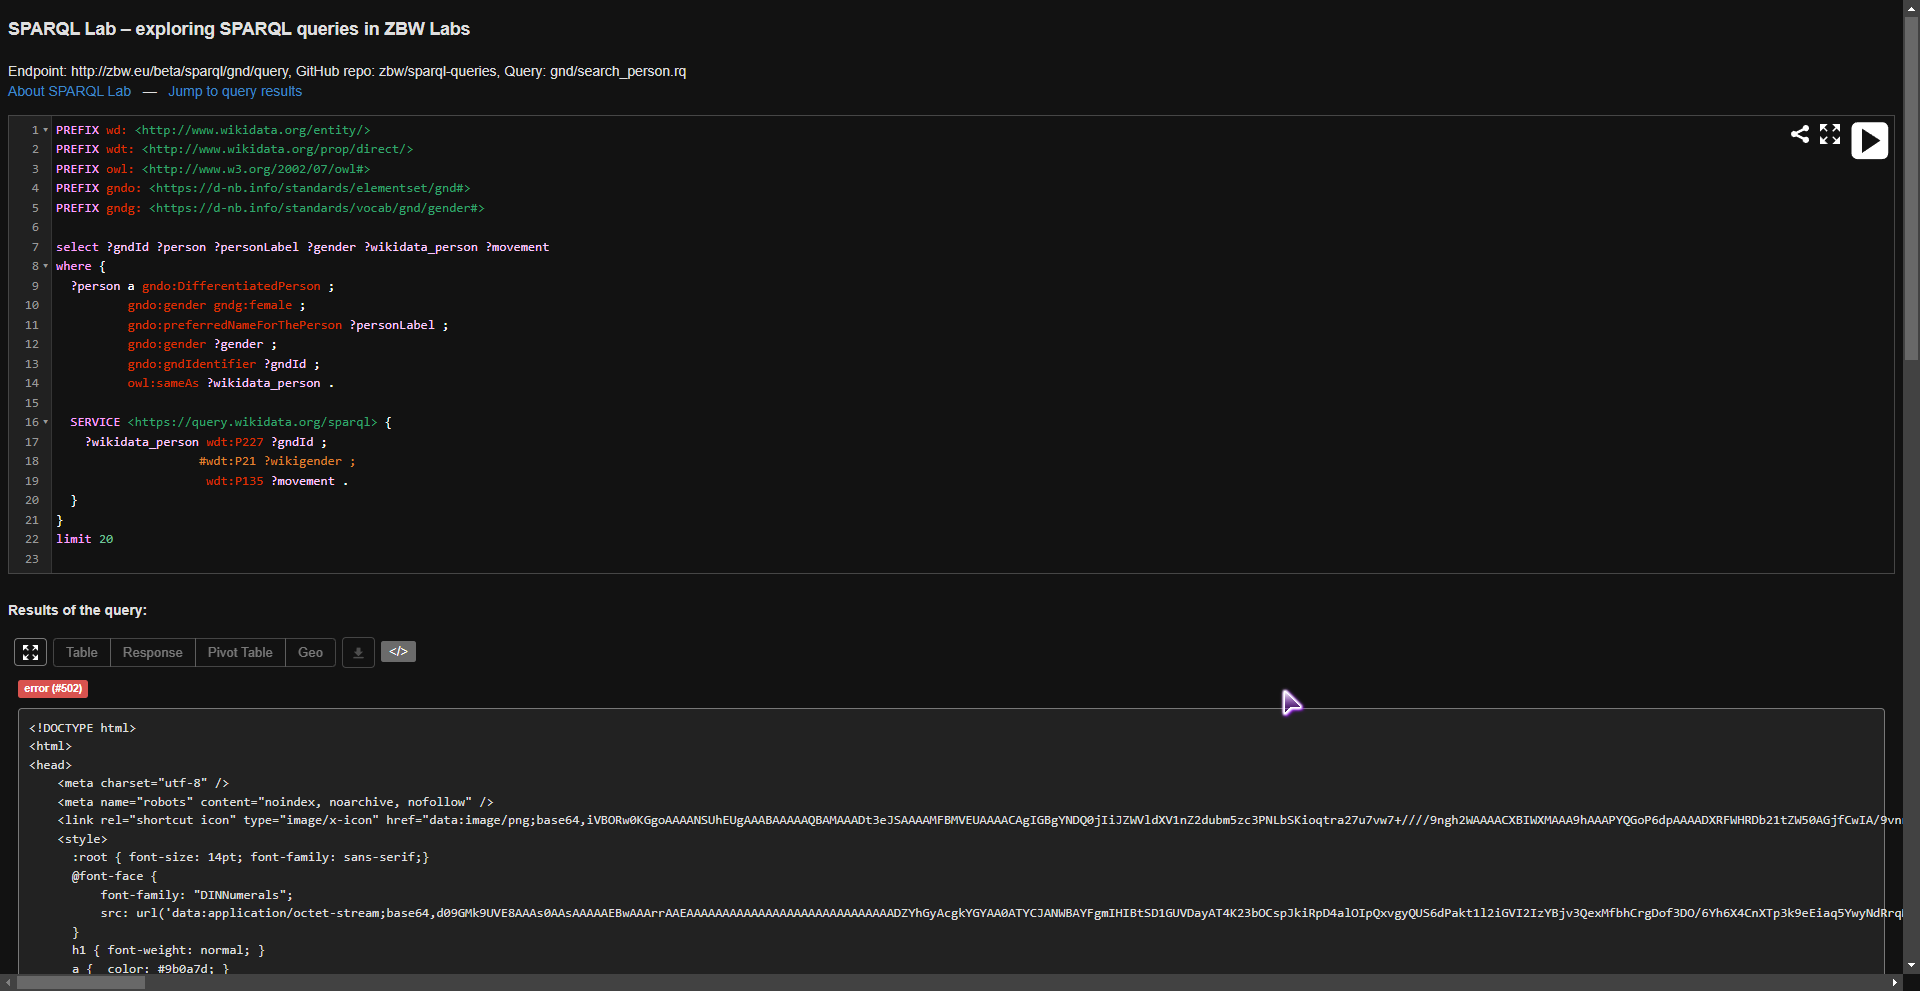

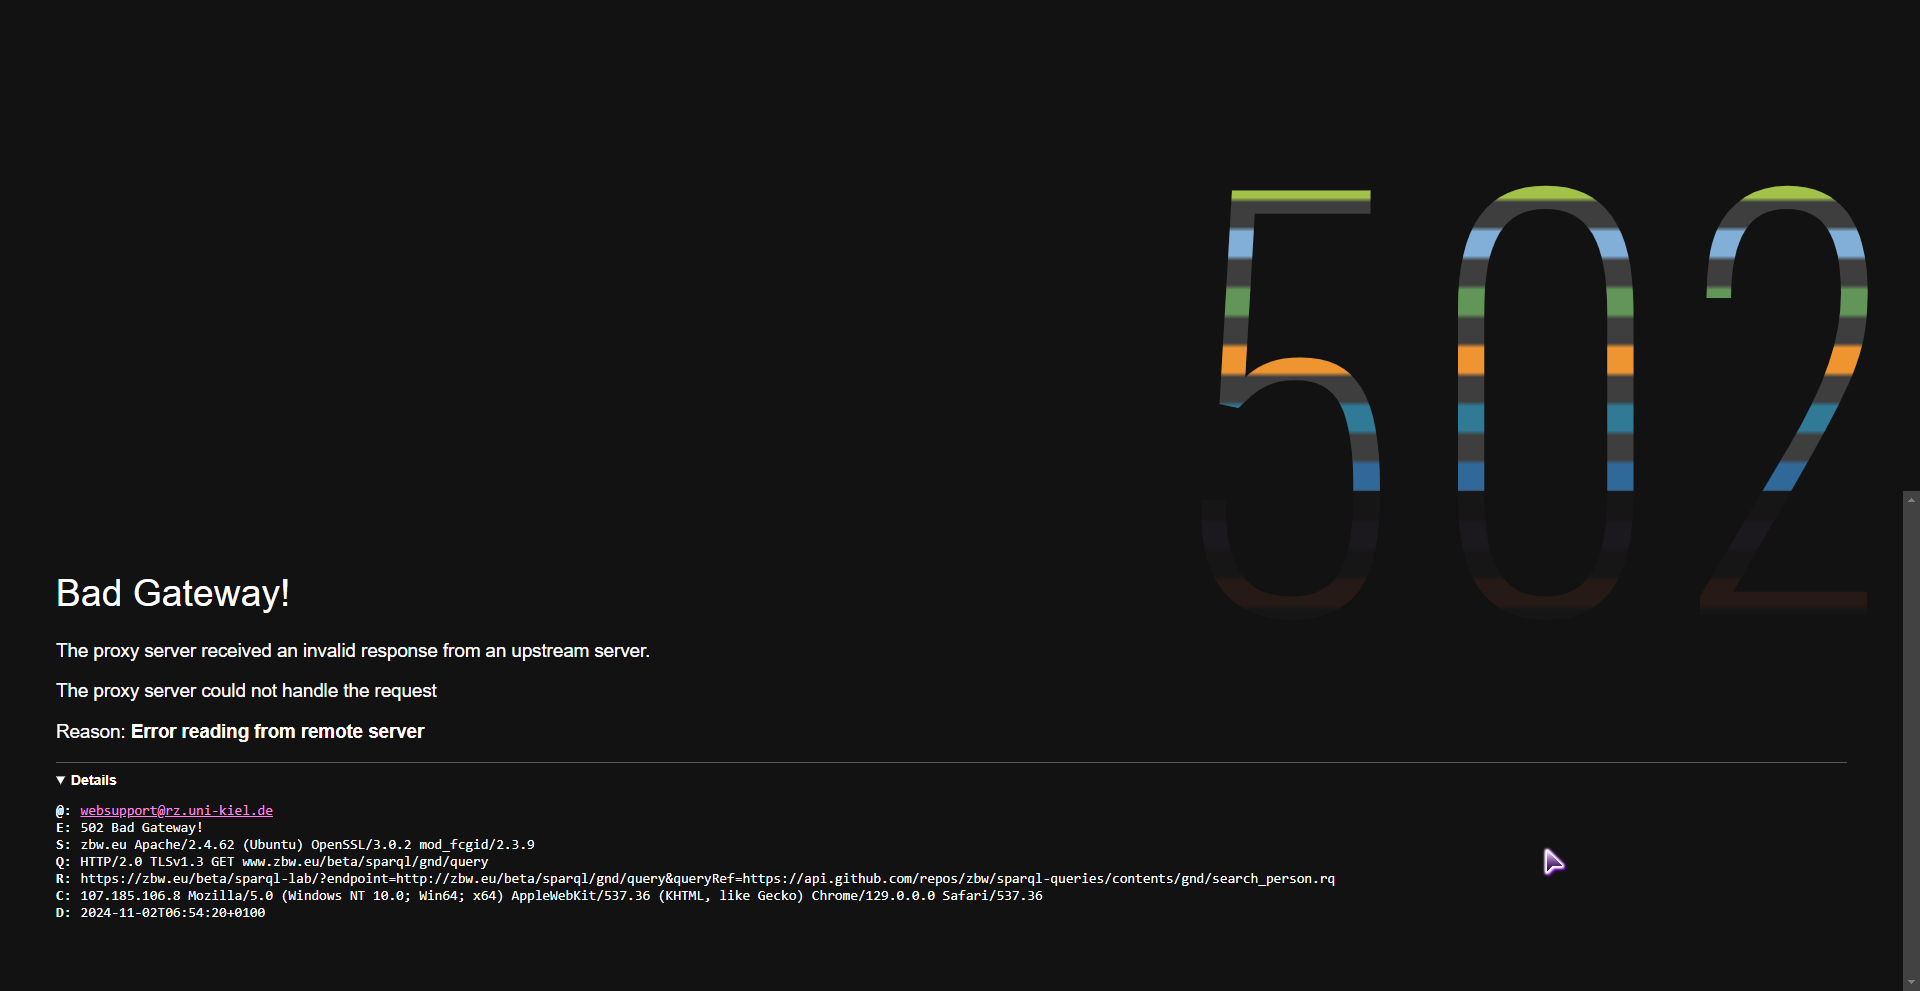

In [ ]:
from IPython.display import Image
Image('htmlerror.png')